# Data Gathering

In [ ]:
# !pip install

In [16]:
import steamreviews

# Basic libraries
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sd
import numpy as np

# For text cleaning 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

import json
import pandas as pd

In [111]:
import plotly as py
import cufflinks as cf 
import plotly.express as px
from plotly.offline import iplot
py.offline.init_notebook_mode(connected=True)
cf.go_offline()

In [5]:
# Game: Momodora: Reverie Under The Moonlight
app_id = 428550
# Game: Pizza Game
# app_id = 710710

# set request parameters 
request_params = {}
request_params['language'] = 'english'

review_dict, query_count = steamreviews.download_reviews_for_app_id(app_id)
# review_dict = steamreviews.load_review_dict(app_id)

[appID = 428550] expected #reviews = 8565


In [6]:
review_dict['query_summary']

{'num_reviews': 100,
 'review_score': 8,
 'review_score_desc': 'Very Positive',
 'total_positive': 8045,
 'total_negative': 520,
 'total_reviews': 8565}

Example of a review scraped in json format.

In [8]:
data = steamreviews.load_review_dict(app_id)
data = data['reviews']
review_dataset = []

for id_num, info in data.items():
    review = {'id_num': id_num,
              'review':info['review'],
              'language':info['language'],
              'voted_up':info['voted_up']}
    
    review_dataset.append(review)

In [9]:
data['50585768']

{'recommendationid': '50585768',
 'author': {'steamid': '76561197986323776',
  'num_games_owned': 112,
  'num_reviews': 3,
  'playtime_forever': 79,
  'playtime_last_two_weeks': 0,
  'playtime_at_review': 79,
  'last_played': 1557556711},
 'language': 'english',
 'review': "There's a lot of things going for this game. Music, atmosphere, item collection, diverse enemies, etc. but one severe drawback from my pov.\nThe game is challenging but not necessarily in a healthy way. Enemies are positioned to attack where it came off as frustrating. With game design, players shouldn't need to approach a new area cautiously for negative surprises - we should clearly see and adapt without needing to die over and over unless we've memorized enemy layouts when they're unclear. It's the (main) difference between Super Mario versus the Syoban Cat game. This game felt as if it was developed to have more 'random' risks than reward.\nTo be fair, I only played an hour and a half on writing this review, but

In [132]:
df = pd.DataFrame(review_dataset)

In [134]:
df.sample(10)

,id_num,review,language,voted_up
5950,31135368,+萌！！我比较喜欢那个摇头的兔子……\n+好像……只有女性角色？\n+上来就选了个困难，结果...,schinese,True
4521,39329769,Retro Darksouls.,english,True
3904,43380678,简单：\n拿到第一个心之容器时：“你获得了心之容器，但你的hp上限已经为最大值，无法增加了！...,schinese,True
5926,31280212,"Una perla del suo genere, non starò qua a dirv...",italian,True
4632,38572009,你只能看到两次奶子！！！！差评！！！！！！,schinese,True
150,90431762,"Pretty good Metroidvania game, but if there's ...",english,True
1833,58407760,Uma obra de arte a unica coisa ruim do jogo é ...,brazilian,True
3889,43447138,Yes,english,True
4333,40411904,Castlevania+Dark Souls=Momodora: Reverie Under...,russian,True
4082,42173121,[b]Story:[/b] The story was fairly intriguing....,english,False


In [135]:
# languages
df_lan = df['language']
df_lan_value_counts = df_lan.value_counts()
df_lan_value_counts.iplot(kind='bar', 
                          xTitle='Language', 
                          yTitle='Number of Reviews', 
                          title='Languages in Steam Reviews')

- English is the prominent language as expected, accounts for nearly 50% of the reviews. In our study, we will only work with English reviews as they offer a reasonable amount of positive and negative reviews for our analysis.

# Basic Text Data Preprocessing

In [137]:
# keep only the english reviews 
df = df[df['language']=='english']
df = df.drop(['id_num', 'language'], axis=1)

In [136]:
# change 'voted_up' to 'recommended'
df = df.rename(columns={"voted_up": "Recommended"})

In [138]:
# check for null values 
df.isnull().sum()

review         0
Recommended    0
dtype: int64

In [139]:
# reset index
df = df.reset_index(drop=True)

# Basic Data Analysis

We look at the number of reviews that have recommended the game or not. 

In [142]:
px.histogram(df, x='Recommended', color='Recommended').update_yaxes(title='Number of Reviews')

We see that the number of users who have recommended the game overshadows those who don’t recommend it. Now keep this one in mind, the amount of reviews recommending the game does indicate something about the game itself and how we’re going to see the reasons behind the recommendation.

# Text Cleaning

In [80]:
' '.join(df['review'].tolist())

'A short but sweet metroidvania that is worth your time, especially if you like getting difficult achievements! awooooo Fun game, but a bit too easy imo Momodora: RUtM is the 4th game in the series and easily the best. It\'s a 2-d action platformer with a simple yet rewarding combat system and difficulty options aplenty. The game is pretty short, about 4 hours on my first play-through (on switch). If you play on normal, I would recommend a second play-through on insane, which adds enemies and drastically lowers the player health bar. Other than that, there isn\'t a ton of replay value unless you want to find all the hidden collectibles. Nevertheless, I would definitely recommend this game. . Short but sweet It\'s really fun! If you like games like Rabi-Ribi or Metroidvania  games in general you\'d def like this game!! Man, it\'s short enuf that my monke brain was able to finish it twice within 7.4hrs. Pacifist achievement tho..enemies just decide that suicide is the best route so it be

In [95]:
# save a copy of the dataframe before any preprocessing
df_1 = df.copy()

Some important cleaning to do with the reviews:
- Uncontract any words to their full form: This usually makes it easier to clean text data and is an optional step. Examples are words like ain’t or we’ll, which is converted into ‘is not’ or ‘we will’.
- Remove any stopwords: These are words that do not provide any sort of information to what we’re trying to find or just appear way too frequently. Articles and prepositions are examples of stopwords.
- Punctuations, emojis and emoticons, numbers: They’re not words, so it’s best to remove them.
- Parts-of-speech: These are tags that indicate the position of the word in the sentence, whether they’re a noun, verb, preposition, etc.
- Lemmatization: It’s a technique or method where the words are converted back into their root or base form, such as converting the word ‘confusing’ to the base form ‘confused’. Makes it easier to understand the words for analysis. The POS tag is also used to lemmatize the words based on their position.

D:\Anaconda3\envs\steam_insider\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Recommended', ylabel='count'>

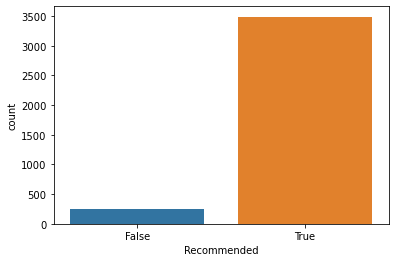

In [10]:
sd.countplot('Recommended',data=text_df)

In [11]:
text_df['Review'] = text_df['Review'].astype(str)
text_df['Length'] = text_df['Review'].apply(lambda x : len(x.split()))

In [12]:
recc_length = text_df[text_df['Recommended'] == True]
norecc_length = text_df[text_df['Recommended'] == False]

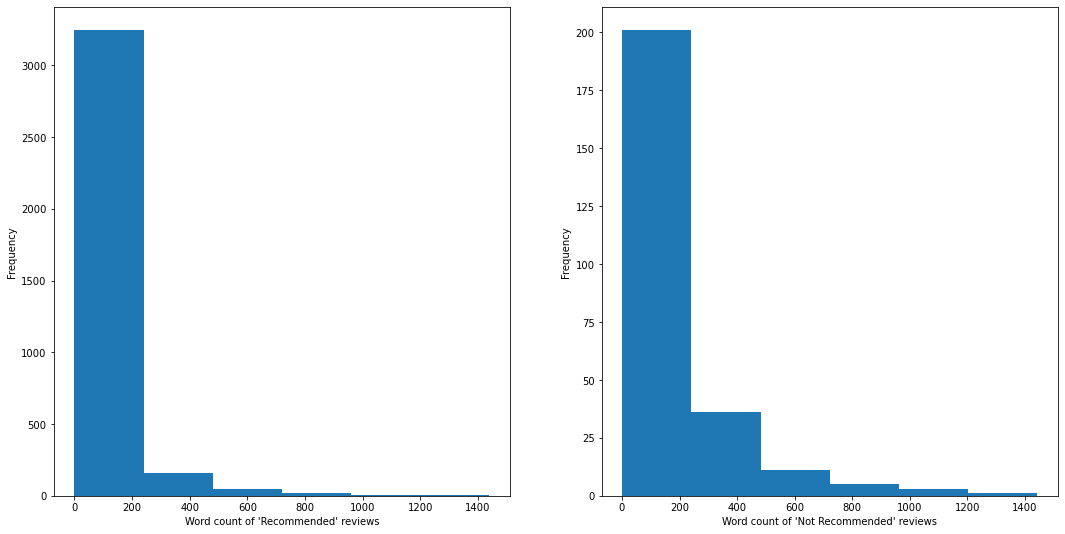

In [13]:
# use same scale 
fig, (ax1,ax2) = pypl.subplots(1,2,figsize=(18,9))

ax1.hist(recc_length['Length'].values,bins=6)
ax1.set(xlabel='Word count of \'Recommended\' reviews',ylabel='Frequency')
ax2.hist(norecc_length['Length'].values,bins=6)
ax2.set(xlabel='Word count of \'Not Recommended\' reviews',ylabel='Frequency')
pypl.show()

# Data Cleaning

In [14]:
text_df.head(10)

,Review,Language,Recommended,Length
1,Absolutely loved this game and the entire atmo...,english,True,17
2,"Good game overall, would recommend",english,True,5
11,I recently finished this game after looking th...,english,True,173
13,Better than Hollow Knight tbh,english,True,5
15,This is a game you really need to take your ti...,english,True,71
17,"Cute, fun and addictive metroidvania that pull...",english,True,22
18,Hardcore in the bad way. Trial and error desig...,english,False,19
30,"Graphically pretty, challenging but not frustr...",english,True,65
31,"If you love Castlevania, you'll probably feel ...",english,True,30
35,Recommended to me by a friend who knew I loved...,english,True,76


In [15]:
import string

contract = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

stopword = stopwords.words('english')
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def penntag(pen):
    morphy_tag = {'NN': 'n', 'JJ': 'a',
                  'VB': 'v', 'RB': 'r'}
    try:
        return morphy_tag[pen[:2]]
    except:
        return 'n'


def comment_cleaner(comm):
    temp_comm = []
    megos = ' '

    # Uncontract any contracted words in our sentences
    uncontracted = ' '.join([contract[word] if word in contract else word for word in comm.lower().split()])

    # Remove any stopwords in our sentences
    stopwords_removed = [word for word in uncontracted.lower().split() if word not in stopword]

    # Use parts-of-speech to regain context after lemmatization 
    POS_words = nltk.pos_tag(stopwords_removed)

    for i in range(0, len(POS_words)):

        # Lemmatize words based on whether they are a noun, preposition etc. based on position
        lemmas = lemma.lemmatize(POS_words[i][0], pos=penntag(POS_words[i][1]))

        # Append or join the words together
        temp_comm.append(lemmas)
    
    # Combine the words into a sentence
    megos = ' '.join(word for word in temp_comm)
    return megos

In [16]:
text_df['Review'] = text_df['Review'].str.replace('[^\w\s]',' ')
text_df['Review'] = text_df['Review'].str.replace('[\d+]',' ')
text_df['Review'] = text_df['Review'].str.replace('(^| ).(( ).)*( |$)',' ')
text_df['Review'] = text_df['Review'].apply(lambda r : comment_cleaner(r))

In [17]:
text_df.head(10)

,Review,Language,Recommended,Length
1,absolutely loved game entire atmosphere everyt...,english,True,17
2,good game overall would recommend,english,True,5
11,recently finish game look steam library game t...,english,True,173
13,well hollow knight tbh,english,True,5
15,game really need take time rush every section ...,english,True,71
17,cute fun addictive metroidvania pull enjoyable...,english,True,22
18,hardcore bad way trial error design hidden ins...,english,False,19
30,graphically pretty challenge frustratingly har...,english,True,65
31,love castlevania probably feel home lot say st...,english,True,30
35,recommend friend know love waifus man game tur...,english,True,76


In [18]:
recc_df = text_df[text_df['Recommended']==True]
notrecc_df = text_df[text_df['Recommended']==False]

In [19]:
count_vect = CountVectorizer(ngram_range=(2,2),stop_words=['game']).fit(text_df['Review'])

In [20]:
def plot_common_ngrams(texts):

    words = count_vect.transform(texts)
    sum_words = words.sum(axis=0)

    ngram_count = []

    for word,index in count_vect.vocabulary_.items():
        ngram_count.append((word,sum_words[0,index]))

    sorted_ngram_count = sorted(ngram_count,key=lambda x: x[1],reverse=True)

    sorted_ngram_count = sorted_ngram_count[:30]

    x = []
    y = []

    for i in sorted_ngram_count:
        x.append(i[0])
        y.append(i[1])

    fig = pypl.figure(figsize=(15,15))
    pypl.barh(x,y)
    fig.gca().invert_yaxis()
    return fig

D:\Anaconda3\envs\steam_insider\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


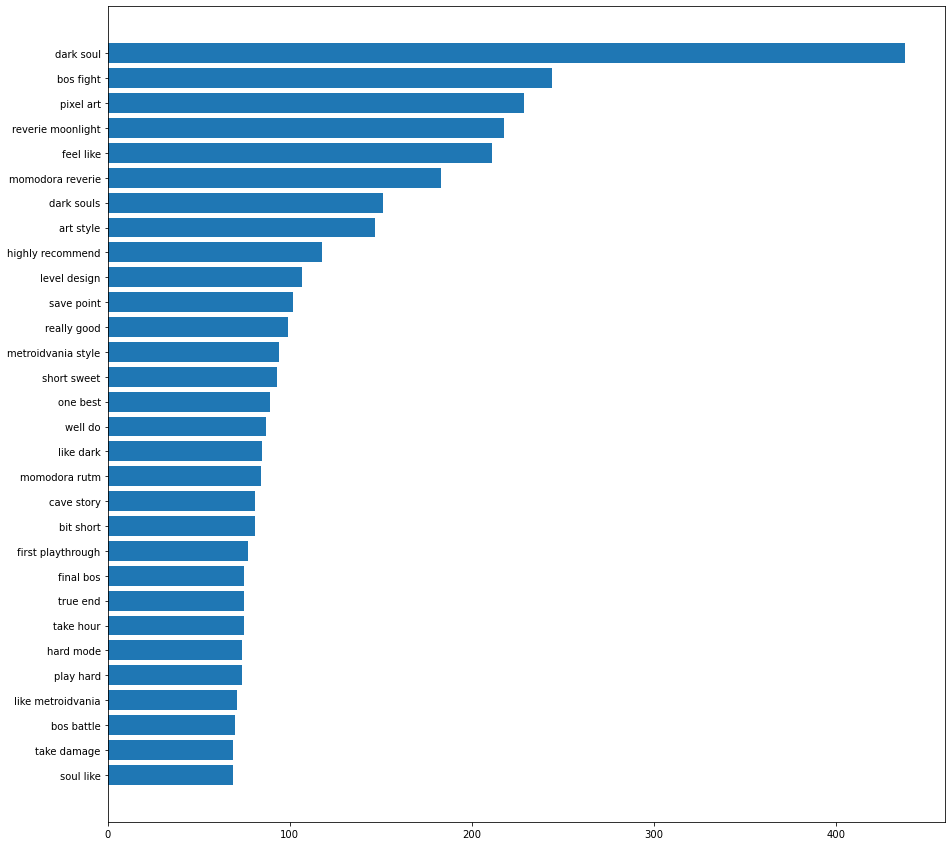

In [21]:
pos_plot = plot_common_ngrams(recc_df['Review'])
pos_plot.show()

D:\Anaconda3\envs\steam_insider\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


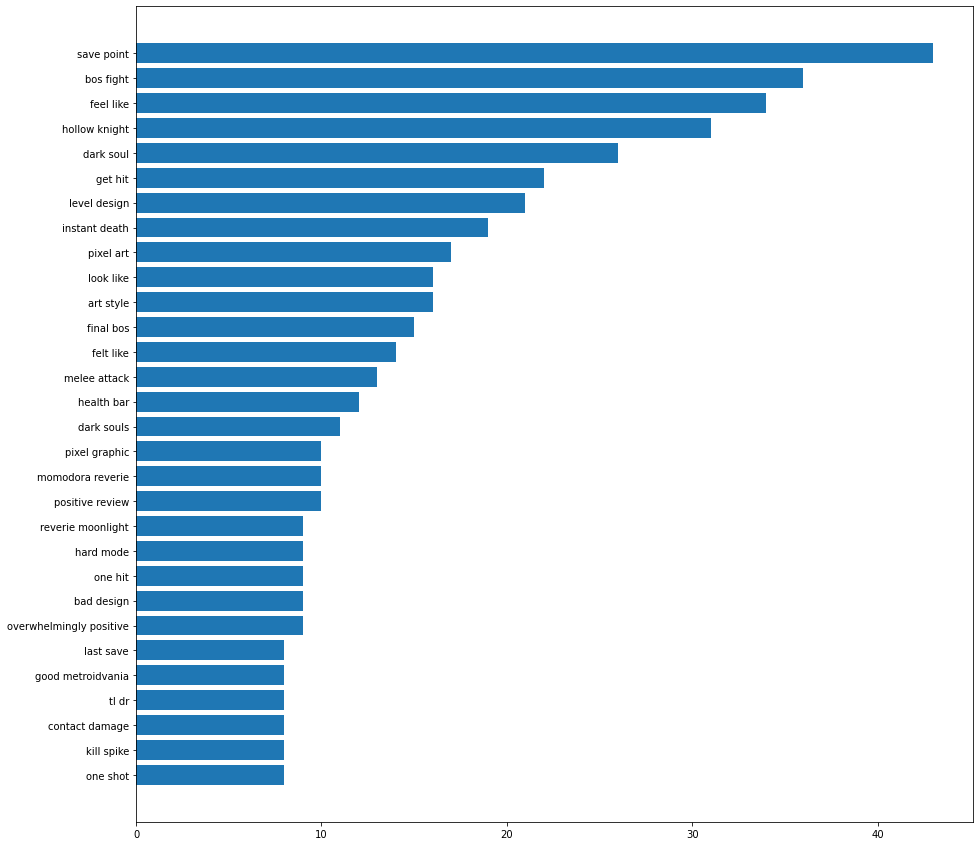

In [22]:
neg_plot = plot_common_ngrams(notrecc_df['Review'])
neg_plot.show()

# Tf-Idf modeling

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
tfvec = TfidfVectorizer(ngram_range=(2,2),stop_words=['game'],max_df=0.9,use_idf=True)
tfvec.fit(text_df['Review'])

TfidfVectorizer(max_df=0.9, ngram_range=(2, 2), stop_words=['game'])

In [25]:
mx = tfvec.transform(notrecc_df['Review'])
fv_tfidf = mx[0]
pdf = pd.DataFrame(fv_tfidf.T.todense(),index=tfvec.get_feature_names(),columns=['tfidf'])
pdf.sort_values(by=["tfidf"],ascending=False)[:15]

,tfidf
hidden instakill,0.285144
save fuck,0.285144
hardcore bad,0.285144
error design,0.285144
instakill trap,0.285144
way trial,0.285144
design hidden,0.285144
trap lose,0.285144
lose everything,0.261989
everything since,0.261989


In [26]:
mx = tfvec.transform(recc_df['Review'])
fv_tfidf = mx[0]
pdf = pd.DataFrame(fv_tfidf.T.todense(),index=tfvec.get_feature_names(),columns=['tfidf'])
pdf.sort_values(by=["tfidf"],ascending=False)[:15]

,tfidf
include visuals,0.341703
feel clean,0.341703
entire atmosphere,0.341703
visuals highly,0.341703
loved entire,0.341703
clean include,0.341703
atmosphere everything,0.325472
absolutely loved,0.297724
everything feel,0.269976
highly recommend,0.178813


# Topic Modeling

In [27]:
from sklearn.decomposition import LatentDirichletAllocation

In [28]:
lda = LatentDirichletAllocation(n_components=10)
lda_count = count_vect.fit_transform(recc_df['Review'])

lda.fit_transform(lda_count)

array([[0.00909143, 0.00909165, 0.00909103, ..., 0.91817636, 0.00909173,
        0.00909202],
       [0.02500079, 0.02500085, 0.02500181, ..., 0.02500123, 0.02500129,
        0.02500462],
       [0.0013334 , 0.00133342, 0.98799918, ..., 0.00133348, 0.00133344,
        0.00133339],
       ...,
       [0.025     , 0.025     , 0.02500297, ..., 0.77499422, 0.025     ,
        0.025     ],
       [0.01666667, 0.01666705, 0.01666779, ..., 0.84999507, 0.01666667,
        0.01666785],
       [0.01250097, 0.01250141, 0.01250169, ..., 0.88748308, 0.01250617,
        0.01250136]])

In [29]:
topic_arr = []

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        temps = []
        for i in topic.argsort()[:-top_n-1:-1]:    
            temps.append((vectorizer.get_feature_names()[i]))
        topic_arr.append(temps)
    
print_topics(lda,count_vect)

In [30]:
rows = [f'Topic {i}' for i in range(0,10)]
tpi = pd.DataFrame(topic_arr)
tpi.index = rows
tpi.T

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,dark soul,dark soul,dark soul,dark soul,dark soul,dark soul,reverie moonlight,dark soul,dark soul,reverie moonlight
1,feel like,feel like,pixel art,pixel art,reverie moonlight,bos fight,momodora reverie,feel like,bos fight,bos fight
2,pixel art,reverie moonlight,bos fight,bos fight,bos fight,pixel art,pixel art,bos fight,feel like,momodora reverie
3,dark souls,pixel art,dark souls,feel like,momodora reverie,feel like,dark soul,pixel art,save point,one best
4,really good,bos fight,like dark,worth price,pixel art,momodora reverie,feel like,pretty good,art style,pixel art
5,bos fight,momodora reverie,art style,dark souls,well do,reverie moonlight,art style,level design,highly recommend,dark soul
6,highly recommend,first run,soul like,first playthrough,really good,dark souls,bos fight,reverie moonlight,momodora rutm,dark souls
7,recommend anyone,dark souls,like metroidvania,metroidvania style,feel like,metroidvania style,level design,hard mode,dark souls,highly recommend
8,really fun,highly recommend,bit short,save point,highly recommend,well worth,maple leaf,play hard,pixel art,short sweet
9,short sweet,art style,take hour,reverie moonlight,one best,great metroidvania,cave story,bos battle,one best,art style


In [31]:
lda = LatentDirichletAllocation(n_components=10)
rfd = count_vect.fit_transform(notrecc_df['Review'])

dlad = lda.fit_transform(rfd)

In [32]:
topa = []

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        topi = []
        for i in topic.argsort()[:-top_n-1:-1]:    
            topi.append((vectorizer.get_feature_names()[i]))
        topa.append(topi)
    
print_topics(lda,count_vect)

In [33]:
rows = [f'Topic {i}' for i in range(0,10)]
tpi = pd.DataFrame(topa)
tpi.index = rows
tpi.T

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,hollow knight,keyboard control,hollow knight,art style,feel like,pixel art,dark soul,get hit,feel like,save point
1,save point,look elsewhere,feel like,design choice,bos fight,felt like,pixel graphic,save point,level design,reverie moonlight
2,bos fight,way short,save point,positive review,kill spike,final bos,bos fight,bos fight,hollow knight,symphony night
3,nothing happen,dark soul,melee attack,look good,bad design,dark soul,save point,hollow knight,like metroidvania,level design
4,art style,art style,instant death,hollow knight,save point,art style,feel like,level design,bos fight,dark soul
5,tl dr,little variety,blind forest,good look,level design,anything else,retro pixel,melee attack,could much,momodora reverie
6,final bos,different attack,ori blind,save point,look like,bos fight,look like,easy avoid,one hit,instant death
7,feel like,worth price,souls series,like go,instant kill,bad end,roll hit,good metroidvania,axiom verge,pixel art
8,would recommend,regular enemy,dark souls,go buy,contact damage,enemy type,really bad,boss attack,good control,get hit
9,collision damage,go back,bos fight,seem like,hard mode,bug reward,hollow knight,get good,health bar,every time
